In [1]:
import os
import numpy as np
import pickle
import time

parent_path = os.path.abspath('../')
thin_slice = 30
data_path = '/data/davos/'
feedback_full_fname = 'reco_feedback_full.txt'
feedback_partial_fname = 'reco_feedback_partial.txt'
length_fname = 'length_full.txt'
sess_or_person_fname = 'reco_sess_or_person.txt'
reco_times_fname = 'reco_times_full.txt'

all_session_ids = []
id_to_feedback = {}
id_to_partial = {}
id_to_time = {}
id_to_length = {}
id_to_types = {}

with open(parent_path + data_path + feedback_full_fname, 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        all_session_ids.append(session_id)
        feedback = np.array(row.split(" ")[1:]).astype(np.float)
        id_to_feedback[session_id] = feedback

with open(parent_path + data_path + feedback_partial_fname, 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        feedback = np.array(row.split(" ")[1:]).astype(np.float)
        id_to_partial[session_id] = feedback

with open(parent_path + data_path + length_fname, 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        length = int(row.split()[1])
        id_to_length[session_id] = length

with open(parent_path + data_path + sess_or_person_fname, 'r') as f:
    rows = f.readlines()
    for row in rows:
        session_id = row.split()[0]
        types = row.rstrip("\n").split(" ")[1:]
        id_to_types[session_id] = types

with open(parent_path + data_path + reco_times_fname, 'r') as f:
    rows = f.readlines()
    for row in rows:
        row = row.rstrip("\n")
        session_id = row.split()[0]
        times = row.split(" ")[1:]
        times_sec = []
        for t in times:
            struct_t = time.strptime(t, '%M:%S.%f')
            tsec = struct_t[4] * 60 + struct_t[5]
            times_sec.append(tsec)
        id_to_time[session_id] = times_sec

In [2]:
import scipy
from scipy.stats import pointbiserialr
import pandas as pd

# Cluster-0: P-type, Cluster-1: I-type.
clusters_fname = 'clusters_full.pkl'
id_to_f_fname = 'id_to_f_full.pkl'
all_rapps_gold_fname = 'all_rapps_gold_full.pkl'

clusters = pickle.load(open(parent_path + data_path + clusters_fname, 'rb'))
id_to_f = pickle.load(open(parent_path + data_path + id_to_f_fname, 'rb'))

id_to_rapp = {}

avg_rapp = {}
total = np.zeros((2, 2))
num = np.zeros((2, 2))

rapp = [[], []]
feedback = [[], []]
feedback_binary = [[], []]
tot_length = np.zeros(2)
num_points = np.zeros(2)

all_rapp_scores = {}
for user_cluster in [0, 1]:
    all_rapp_scores[user_cluster] = {}
    for task_perf in [0, 1]:
        all_rapp_scores[user_cluster][task_perf] = []

count = 0
for i, sid in enumerate(all_session_ids):
    count += id_to_feedback[sid].shape[0]
    f = id_to_f[sid]
    id_to_rapp[sid] = np.array([f(t).tolist() for t in id_to_time[sid]])
    c = int(clusters[int(sid)])    
    L = id_to_rapp[sid].tolist()
    
    for j, rapp_val in enumerate(L):
        if (id_to_types[sid][j] in ['P', 'S']) and (id_to_partial[sid][j] in [1, 2, 3, 4]):
            rapp[c].append(id_to_rapp[sid][j])

            if id_to_partial[sid][j] == 1:
                feedback[c].append(4)
                feedback_binary[c].append(1)
            if id_to_partial[sid][j] == 4:
                feedback[c].append(3)
                feedback_binary[c].append(0)
            if id_to_partial[sid][j] == 2:
                feedback[c].append(2)
                feedback_binary[c].append(0)
            if id_to_partial[sid][j] == 3:
                feedback[c].append(1)
                feedback_binary[c].append(0)

            # Total rapport and number of recos for rejects
            total[c][0] += id_to_rapp[sid][j] * (1 - id_to_feedback[sid][j])
            num[c][0] += 1 - id_to_feedback[sid][j]
            val = id_to_rapp[sid][j] * (1 - id_to_feedback[sid][j])
            if val > 0:
                all_rapp_scores[c][0].append(val)

            # Total rapport and number of recos for accepts
            total[c][1] += id_to_rapp[sid][j] * (id_to_feedback[sid][j])
            num[c][1] += id_to_feedback[sid][j]
            val = id_to_rapp[sid][j] * (id_to_feedback[sid][j])
            if val > 0:
                all_rapp_scores[c][1].append(val)

            tot_length[c] += id_to_length[sid]
            num_points[c] += 1

print("Average rapport: ")
print(total/num)
print("Total recos: ")
print(num)
print("Total number of recommendations: ", count)
print("Avg. length: ", tot_length/num_points)
print("Total number of recos (filtered): ", num_points)

for user_cluster in [0, 1]:
    for task_perf in [0, 1]:
        print("Average: ", np.average(np.array(all_rapp_scores[user_cluster][task_perf])))
        print("Std. Dev.: ", np.std(np.array(all_rapp_scores[user_cluster][task_perf])))
        
for user_cluster in [0, 1]:
    x = []
    for task_perf in [0, 1]:
        x.extend(all_rapp_scores[user_cluster][task_perf])
    print("Average overall: ", np.average(np.array(x)))
    print("Std. Dev. overall: ", np.std(np.array(x)))

for i in range(2):
#     df = pd.DataFrame(list(zip(rapp[i], feedback[i])))
#     df.to_csv(str(i)+'.csv')
    print("Pearson correlation coefficient: ")
    print(np.corrcoef(np.array(rapp[i]), np.array(feedback[i])))
    print("Spearman correlation coefficient: ")
    print(scipy.stats.spearmanr(np.array(rapp[i]), np.array(feedback[i])))

all_rapps_gold = []
for i in range(2):
    all_rapps_gold.extend(rapp[i])
pickle.dump(all_rapps_gold, open(parent_path + data_path + all_rapps_gold_fname, 'wb'))

Average rapport: 
[[4.19303685 3.99120156]
 [4.04699534 4.42710609]]
Total recos: 
[[33. 71.]
 [20. 33.]]
Total number of recommendations:  184
Avg. length:  [319.52884615 328.1509434 ]
Total number of recos (filtered):  [104.  53.]
Average:  4.193036848840708
Std. Dev.:  0.8378225200950944
Average:  3.991201559529796
Std. Dev.:  0.8072118074071345
Average:  4.0469953417324
Std. Dev.:  0.6863004068176916
Average:  4.427106092389698
Std. Dev.:  0.8880830676665156
Average overall:  4.055245449407298
Std. Dev. overall:  0.822431663832437
Average overall:  4.283668073273736
Std. Dev. overall:  0.8383071736113287
Pearson correlation coefficient: 
[[1.         0.00198046]
 [0.00198046 1.        ]]
Spearman correlation coefficient: 
SpearmanrResult(correlation=-0.058484008949332617, pvalue=0.5553791743535292)
Pearson correlation coefficient: 
[[1.         0.28205335]
 [0.28205335 1.        ]]
Spearman correlation coefficient: 
SpearmanrResult(correlation=0.20320452993634874, pvalue=0.14446867

In [28]:
from scipy.stats import spearmanr

keys = all_session_ids
values = [0 for _ in all_session_ids]

avg_rapp = {}
avg_perf = {}

for user_cluster in [0, 1]:
    avg_rapp[user_cluster] = []
    avg_perf[user_cluster] = []

overall_rapp = []
overall_perf = []

n = 0

print(avg_rapp)
print(avg_perf)

for i, sid in enumerate(all_session_ids):
    count += id_to_feedback[sid].shape[0]
    f = id_to_f[sid]
    c = int(clusters[int(sid)])
    
    if (len(id_to_time[sid]) in [1, 2, 3, 4, 5, 6]) and (id_to_partial[sid][j] in [1, 4]):
        n += 1
        rapp = np.average(np.array([f(t).tolist() for t in id_to_time[sid]]))
        perf = np.average(np.array(id_to_feedback[sid].tolist()))
        avg_rapp[c].append(rapp)
        avg_perf[c].append(perf)
        overall_rapp.append(rapp)
        overall_perf.append(perf)
        
        if c == 1:
            print(sid)
            print([f(t).tolist() for t in id_to_time[sid]])
            print(id_to_feedback[sid].tolist())

print(np.corrcoef(np.array(overall_rapp), np.array(overall_perf)))

for i in [0, 1]:
    print(np.corrcoef(np.array(avg_rapp[i]), np.array(avg_perf[i])))
print(n)

{0: [], 1: []}
{0: [], 1: []}
514928
[2.9257409824802476, 5.093730782769486, 4.07708021510575, 4.155573041379866]
[1.0, 1.0, 1.0, 0.0]
515843
[5.772024793833459, 4.955322741811836, 5.058984377065214, 4.0]
[1.0, 1.0, 1.0, 1.0]
516135
[4.898434668320633]
[0.0]
1001335
[3.278487033008044]
[1.0]
1001918
[4.964381484026108, 3.8794890114550586, 4.0029048436963235]
[1.0, 0.0, 0.0]
1002281
[4.722473684210525, 3.9002716049382724, 3.9859753086419754]
[1.0, 1.0, 0.0]
1002655
[3.2721405508072166, 2.7957480769230765, 3.457679012345678, 4.219183285849951]
[1.0, 1.0, 1.0, 0.0]
2001299
[3.982119790814379, 4.435573883161512, 3.945761229749631, 4.3368766704849175]
[1.0, 0.0, 0.0, 0.0]
2016938
[4.092980861244019, 4.566063441431863]
[1.0, 1.0]
509921
[4.000000000000001, 3.9999999999999996, 3.999999999999999, 3.999999999999999]
[1.0, 0.0, 1.0, 0.0]
509969
[5.0395240899018665, 5.999999999999999]
[1.0, 1.0]
510275
[4.41542162126629, 4.9317446382601515, 2.6572229474407423]
[1.0, 1.0, 0.0]
510734
[5.0494551440

In [22]:
rapp = {}
num = {}

for user_cluster in [0, 1]:
    rapp[user_cluster] = {}
    num[user_cluster] = {}
    for reject_type in [2, 3, 4]:
        rapp[user_cluster][reject_type] = 0
        num[user_cluster][reject_type] = 0

print(rapp)
print(num)

for i, sid in enumerate(all_session_ids):
    f = id_to_f[sid]
    c = int(clusters[int(sid)])
    
    feedbacks = id_to_feedback[sid].tolist()
    
    for j, fee in enumerate(feedbacks):
        if id_to_types[sid][j] in ['S']: 
            if int(fee) in [2, 3, 4]:
                rapp[c][fee] += [f(t).tolist() for t in id_to_time[sid]][j]
                num[c][fee] += 1

print(rapp)
print(num)

{0: {2: 0, 3: 0, 4: 0}, 1: {2: 0, 3: 0, 4: 0}}
{0: {2: 0, 3: 0, 4: 0}, 1: {2: 0, 3: 0, 4: 0}}
{0: {2: 3.9716208337044243, 3: 16.810801609533463, 4: 13.412138314416108}, 1: {2: 8.022814864797319, 3: 11.814232916545508, 4: 0}}
{0: {2: 1, 3: 4, 4: 3}, 1: {2: 2, 3: 3, 4: 0}}


Cluster-1 (I-type):
- 3.75
- 4.37

Cluster-2 (P-type):
- 3.98
- 3.94

Next steps:
1) Add word count information for cluster determination
2) Restrict conversational strategy profiling to the initial part of the conversation (before first recommendation)
3) Change reject to accept for "interesting reco (but already know this person)"
4) Calculate correlation

0.09433962264150944
0.3018867924528302
0.20754716981132076
0.18867924528301888
0.18867924528301888


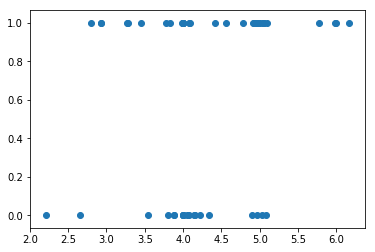

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample
from xgboost import XGBClassifier
from sklearn.linear_model import Perceptron
from sklearn.svm import LinearSVC
from sklearn import preprocessing
from sklearn.model_selection import LeaveOneOut
import matplotlib.pyplot as plt

scaler = preprocessing.StandardScaler()

#np.random.seed(0)

clust = 1
clf = LogisticRegression(penalty = 'l1', random_state=200)

if clust == 'all':
    X = np.concatenate((np.array(rapp[0])[:, np.newaxis], np.array(rapp[1])[:, np.newaxis]), axis=0)
    y = np.concatenate((np.array(feedback_binary[0]), np.array(feedback_binary[1])), axis=0)
else:
    X = np.array(rapp[clust])[:, np.newaxis]
    y = np.array(feedback_binary[clust])

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

# print(np.average(X[np.where(y == 0)[0]]))
# print(np.std(X[np.where(y == 0)[0]]))
# print(np.average(X[np.where(y == 1)[0]]))
# print(np.std(X[np.where(y == 1)[0]]))

print(np.shape(y[np.where(X < 3)[0]])[0]/53)
# print(np.average(y[np.where(X < 3)[0]]))

print(np.shape(y[np.where((X > 3) & (X < 4))[0]])[0]/53)
# print(np.average(y[np.where((X > 3) & (X < 4))[0]]))

print(np.shape(y[np.where((X > 4) & (X < 4.5))[0]])[0]/53)
# print(np.average(y[np.where((X > 4) & (X < 4.5))[0]]))

print(np.shape(y[np.where((X > 4.5) & (X < 5))[0]])[0]/53)
# print(np.average(y[np.where((X > 4.5) & (X < 5))[0]]))

print(np.shape(y[np.where((X > 5))[0]])[0]/53)
# print(np.average(y[np.where((X > 5))[0]]))

plt.scatter(rapp[clust], y)
plt.show()

# Resample
# y_0 = y_train[np.where(y_train == 0)[0]]
# X_0 = X_train[np.where(y_train == 0)[0]]

# y_1 = y_train[np.where(y_train == 1)[0]]
# X_1 = X_train[np.where(y_train == 1)[0]]

# X_0, y_0 = resample(X_0, y_0, replace=True, n_samples=X_1.shape[0])
# X_train = np.concatenate((X_0, X_1), axis=0)
# y_train = np.concatenate((y_0, y_1), axis=0)

# plt.scatter(rapp[clust], feedback[clust])
# plt.show()

# loo = LeaveOneOut()
# loo.get_n_splits(X)

# total_acc = 0
# count = 0
# for train_index, test_index in loo.split(X):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     # Resample
#     y_0 = y_train[np.where(y_train == 0)[0]]
#     X_0 = X_train[np.where(y_train == 0)[0]]

#     y_1 = y_train[np.where(y_train == 1)[0]]
#     X_1 = X_train[np.where(y_train == 1)[0]]

#     X_0, y_0 = resample(X_0, y_0, replace=True, n_samples=X_1.shape[0])
#     X_train = np.concatenate((X_0, X_1), axis=0)
#     y_train = np.concatenate((y_0, y_1), axis=0)
    
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     acc = accuracy_score(y_pred, y_test)
#     total_acc += acc
#     count += 1

# print(total_acc/count)
    

# scaler.fit(X_train)
# print(scaler.mean_)
# print(scaler.scale_)

#clf.fit(X_train, y_train)

#X_test = scaler.transform(X_test)
# y_pred = clf.predict(X_test)
# acc = accuracy_score(y_pred, y_test)
# print(acc)
# print(y_pred)
# print(y_test)

# conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
# print('Confusion matrix:\n', conf_mat)

# y_pred = clf.predict(X_train)
# acc = accuracy_score(y_pred, y_train)
# print(acc)

# print(clf.coef_)
# print(clf.intercept_)

(array([49.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 74.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <a list of 50 Patch objects>)

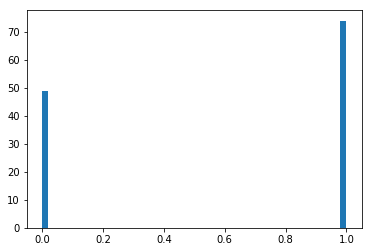

In [45]:
min_x = 2
max_x = 6

xlims = np.arange(min_x, max_x + 1)
acceptance_rate = np.zeros(max_x - min_x + 1)
for i in range(min_x, max_x):
    acceptance_rate[i-2] = np.average(y[np.where((X > i) & (X <= i+1))[0]])

plt.hist(y, bins=50)

In [13]:
import math

muA = 0.23
muB = 0.18
stdA = 0.01
stdB = 0.01
nA = 10
nB = 10
sAB = math.sqrt(((nA-1)*stdA**2 + (nB-1)*stdB**2)/(nA+nB-2))

t_den = sAB * math.sqrt(1.0/nA + 1.0/nB)
t_num = abs(muA-muB)
print(t_num/t_den)

11.18033988749895
